# Optimising Lockdown Policies for Epidemic Control using Reinforcement Learning
---



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xkotaro/lockdowneR/blob/master/test.ipynb)

## Install dependencies

In [ ]:
# If you are running on Google Colab, uncomment below to install the necessary dependencies 
# before beginning the exercise.

print("Setting up colab environment")
!pip uninstall -y -q pyarrow
!pip install -q https://s3-us-west-2.amazonaws.com/ray-wheels/latest/ray-0.8.0.dev5-cp36-cp36m-manylinux1_x86_64.whl
!pip install -q ray[debug]

# A hack to force the runtime to restart, needed to include the above dependencies.
print("Done installing! Restarting via forced crash (this is not an issue).")
import os
os._exit(0)

Setting up colab environment
     |████████████████████████████████| 75.9MB 54kB/s 
     |████████████████████████████████| 81kB 6.0MB/s 
     |████████████████████████████████| 2.9MB 6.7MB/s 


In [1]:
# !pip install -U ray
# !pip install tree

!pip install -q https://files.pythonhosted.org/packages/25/26/80a5b9f68e09d75da924eb9702edeffa9e141d7bc252a27ce6fe178b7b6d/ray-0.8.4-cp36-cp36m-manylinux1_x86_64.whl
!pip install -q https://files.pythonhosted.org/packages/7c/39/7eb5f98d24904e0f6d3edb505d4aa60e3ef83c0a58d6fe18244a51757247/aiohttp-3.6.2-cp36-cp36m-manylinux1_x86_64.whl
!pip install -q https://files.pythonhosted.org/packages/30/2e/3ab2f1fb72571f75013db323a3799d505d99f3bc203513604f1ffb9b7858/multidict-4.7.5-cp36-cp36m-manylinux1_x86_64.whl
!pip install -q https://files.pythonhosted.org/packages/e1/1e/5a4441be21b0726c4464f3f23c8b19628372f606755a9d2e46c187e65ec4/async_timeout-3.0.1-py3-none-any.whl
!pip install -q https://files.pythonhosted.org/packages/46/03/07c4894aae38b0de52b52586b24bf189bb83e4ddabfe2e2c8f2419eec6f4/idna-ssl-1.1.0.tar.gz
!pip install -q https://files.pythonhosted.org/packages/95/8f/0209fc5d975f839344c33c822ff2f7ef80f6b1e984673a5a68f960bfa583/yarl-1.4.2-cp36-cp36m-manylinux1_x86_64.whl

     |████████████████████████████████| 20.2MB 1.2MB/s 
     |████████████████████████████████| 1.2MB 52.5MB/s 
     |████████████████████████████████| 266kB 54.4MB/s 
     |████████████████████████████████| 153kB 53.3MB/s 
     |████████████████████████████████| 153kB 5.6MB/s 
     |████████████████████████████████| 256kB 4.9MB/s 


In [2]:
import copy
import numpy as np
from numpy import random
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import scipy.integrate


import networkx as nx
import matplotlib.pyplot as plt

import gym

from tqdm.notebook import tqdm

import datetime

In [3]:
# If you are running on Google Colab, please install TensorFlow 2.0 by uncommenting below..

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [4]:
!pip install lz4

     |████████████████████████████████| 1.8MB 5.4MB/s 


In [5]:
#!pip install lz4
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from ray.rllib.models import ModelCatalog

## Check to see the artificial data

In [6]:
POPULATION = 51829538
NUM_CITIES = 17

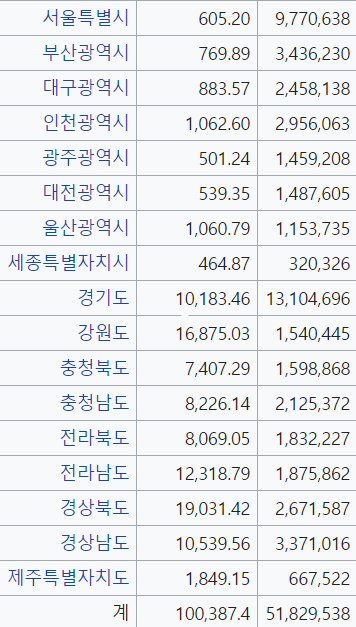

In [7]:
population = np.random.randint(1, 3, NUM_CITIES).astype('int64')
population[0] = 9770638
population[1] = 3436230
population[2] = 2458138
population[3] = 2956063
population[4] = 1459208
population[5] = 1487605
population[6] = 1153735
population[7] = 320326
population[8] = 13104696
population[9] = 1540445
population[10] = 1598868
population[11] = 2125372
population[12] = 1832227
population[13] = 1875862
population[14] = 2671587
population[15] = 3371016
population[16] = 667522

서울 : 37.5665, 126.9780
부산 : 35.1796, 129.0756
대구 : 35.8714, 128.6014
인천 : 37.4563, 126.7052
광주 : 35.1595, 126.8526
대전 : 36.3504, 127.3845
울산 : 35.5384, 129.3114
세종 : 36.5, 127.266667
경기 : 37.4138, 127.5183
강원 : 37.8228, 128.1555
충북 : 36.8000, 127.7000
충남 : 36.5184, 126.8000
전북 : 35.7175, 127.1530
전남 : 34.8679, 126.9910
경북 : 36.4919, 128.8889
경남 : 35.4606, 128.2132
제주 : 33.4996, 126.5312

In [8]:
locs = np.random.rand(NUM_CITIES, 2)
locs[0] = [37.5665, 126.9780]
locs[1] = [35.1796, 129.0756]
locs[2] = [ 35.8714, 128.6014]
locs[3] = [ 37.4563, 126.7052]
locs[4] = [35.1595, 126.8526]
locs[5] = [36.3504, 127.3845]
locs[6] = [35.5384, 129.3114]
locs[7] = [36.5, 127.266667]
locs[8] = [37.4138, 127.5183]
locs[9] = [37.8228, 128.1555]
locs[10] = [36.8000, 127.7000]
locs[11] = [36.5184, 126.8000]
locs[12] = [35.7175, 127.1530]
locs[13] = [34.8679, 126.9910]
locs[14] = [36.4919, 128.8889]
locs[15] = [35.4606, 128.2132]
locs[16] = [33.4996, 126.5312]

In [9]:
A = np.outer(population,population)/(np.sqrt(squareform(pdist(locs)))+np.eye(len(locs)))#마지막 항은 0으로 나눠주지 않게하기 위한 수작.
np.fill_diagonal(A, 0)
A = A/np.max(A) 

In [ ]:
G = nx.from_numpy_array(A)
node_colors = [0] * len(A) #이건 왜이렇게 햇지? [0*100]
node_sizes = population.tolist() # 인구많을수록 노드크기 커짐
cmap = plt.cm.jet

pos = {
        n: locs[i]
        for i, n in enumerate(G.nodes)
    }


# for key in list(dic):
#     dic.pop(key)

# for (u,v,d) in list(G.edges(data=True)): 
#     if d["weight"] <= 0.12: #엣지의 강도가 0.12보다 낮으면 없앴구만!!
#         G.remove_edge(u, v)

plt.figure(figsize=(200,200))
nx.draw_networkx(G,
                 pos,
                 with_labels=None,
                 node_color=node_colors,
                 node_size=node_sizes,
                 edge_color='C',
                 alpha=0.6
                 )
plt.grid(True)
plt.show()

## Class for the epidemic model

In [11]:
class EpiModel(object):
# Taken from https://github.com/DataForScience/Epidemiology101/
    def __init__(self, compartments=None):
        self.transitions = nx.MultiDiGraph()
        
        if compartments is not None:
            self.transitions.add_nodes_from([comp for comp in compartments])
    
    def add_interaction(self, source, target, agent, rate):        
        self.transitions.add_edge(source, target, agent=agent, rate=rate)        
        
    def add_spontaneous(self, source, target, rate):
        self.transitions.add_edge(source, target, rate=rate)
        
    def _new_cases(self, population, time, pos):
        diff = np.zeros(len(pos))
        N = np.sum(population)        
        
        for edge in self.transitions.edges(data=True):
            source = edge[0]
            target = edge[1]
            trans = edge[2]
            
            rate = trans['rate']*population[pos[source]]
            
            if 'agent' in trans:
                agent = trans['agent']
                rate *= population[pos[agent]]/N
                
            diff[pos[source]] -= rate
            diff[pos[target]] += rate
            
        return diff
    
    def __getattr__(self, name):
        if 'values_' in self.__dict__:
            return self.values_[name]
        else:
            raise AttributeError("'EpiModel' object has no attribute '%s'" % name)

    def simulate(self, timesteps, **kwargs):
        pos = {comp: i for i, comp in enumerate(kwargs)}
        population=np.zeros(len(pos), dtype='int')

        for comp in pos:
            population[pos[comp]] = kwargs[comp]

        values = []
        values.append(population)

        comps = list(self.transitions.nodes)
        time = np.arange(1, timesteps, 1, dtype='int')

        for t in time:
            pop = values[-1]
            new_pop = values[-1].copy()
            N = np.sum(pop)


            for comp in comps:
                trans = list(self.transitions.edges(comp, data=True))             

                prob = np.zeros(len(comps), dtype='float')

                for _, node_j, data in trans:
                    source = pos[comp]
                    target = pos[node_j]

                    rate = data['rate']

                    if 'agent' in data:
                        agent = pos[data['agent']]
                        rate *= pop[agent]/N

                    prob[target] = rate

                prob[source] = 1-np.sum(prob)

                delta = random.multinomial(pop[source], prob)
                delta[source] = 0

                changes = np.sum(delta)

                if changes == 0:
                    continue

                new_pop[source] -= changes

                for i in range(len(delta)):
                    new_pop[i] += delta[i]

            values.append(new_pop)

        values = np.array(values)
        self.values_ = pd.DataFrame(values[1:], columns=comps, index=time)
    
    def integrate(self, timesteps, **kwargs):
        pos = {comp: i for i, comp in enumerate(kwargs)}
        population=np.zeros(len(pos))
        
        for comp in pos:
            population[pos[comp]] = kwargs[comp]
        
        time = np.arange(1, timesteps, 1)

        self.values_ = pd.DataFrame(scipy.integrate.odeint(self._new_cases, population, time, args=(pos,)), columns=pos.keys(), index=time)

## Make Gym Environment

In [12]:
class Game(MultiAgentEnv):
    
    def __init__(self):
        self.NUM_CITIES = 17
        
        
        self.NUM_INITIAL_INFECTED = 50
        self.POPULATION = 51829538
        
        self.num_agents = 3
        self.agent_ids = list(range(self.num_agents))
        
        self.action_space_dict = dict(zip(self.agent_ids, [gym.spaces.Discrete(2)] * self.num_agents))
        self.observation_space_dict = dict(zip(self.agent_ids, [
            gym.spaces.Box(low=-np.inf, high=np.inf, shape=(8,))] * self.num_agents))

        self.C_DEAD = 25 #사망자에 대한 패널티 논문에선 2.5*10^9
        self.C_INF = 10 #감염자에 대한 패널티 논문에선 5*10^5
        self.C_LOCK = 10 #락다운에 대한 패널티 논문에선 1/364
        self.C_ALPHA = 2
        self.C_BETA = 0.001

        self.week = 0
        self.max_week = 52

        self.global_susceptible = np.zeros(364)
        self.global_exposed = np.zeros(364)
        self.global_asymptomatic = np.zeros(364) # IA
        self.global_symptomatic = np.zeros(364)
        self.global_recovered = np.zeros(364)
        self.global_dead = np.zeros(364)

        self.susceptible = np.zeros(self.NUM_CITIES)
        self.exposed = np.zeros(self.NUM_CITIES)
        self.asymptomatic = np.zeros(self.NUM_CITIES)
        self.symptomatic = np.zeros(self.NUM_CITIES)
        self.recovered = np.zeros(self.NUM_CITIES)
        self.dead = np.zeros(self.NUM_CITIES)

        self.u_onoff = np.ones([self.NUM_CITIES,364])
        self.local_increase = np.zeros(self.NUM_CITIES)
        self.death_increase = np.zeros(self.NUM_CITIES)

        
        self.A, self.population = self.make_world()
        self.initial_infected = self.make_initial_infected()

        self.ExpPopIn = np.zeros(self.NUM_CITIES)
        
    
    def step(self, action_dict):
        
        if self.week > 0:
            for city in range(self.NUM_CITIES):
                self.u_onoff[city,7*self.week:7*self.week+8] = action_dict[city]

        symptomatic_prev = copy.deepcopy(self.symptomatic)
        dead_prev = copy.deepcopy(self.dead)

        self.susceptible,self.exposed,self.asymptomatic,self.symptomatic,self.recovered,self.dead,\
        self.global_susceptible,self.global_exposed,self.global_asymptomatic,self.global_symptomatic,\
        self.global_recovered,self.global_dead,self.ExpPopIn =\
        self.run_simulation()
        
        self.local_increase = self.symptomatic - symptomatic_prev
        self.death_increase = self.dead - dead_prev
        
        reward = {city: self.get_reward(city) for city in range(self.NUM_CITIES)}
        
        observation = {city: self.get_observation(city) for city in range(self.NUM_CITIES)}
        
        self.week += 1
        if self.week == self.max_week:
            
            colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

            fig, ax = plt.subplots(1)
            (pd.DataFrame(self.global_susceptible)).plot(color=colors[0], linestyle='-', label='Susceptible', ax=ax)
            (pd.DataFrame(self.global_exposed)).plot(color=colors[4], linestyle='-', label='Exposed', ax=ax)
            (pd.DataFrame(self.global_asymptomatic)).plot(color=colors[1], linestyle=':', label='Asymptomatic', ax=ax)
            (pd.DataFrame(self.global_symptomatic)).plot(color=colors[1], linestyle='--', label='Symptomatic', ax=ax)
            (pd.DataFrame(self.global_recovered)).plot(color=colors[2], linestyle='-', label='Recovered', ax=ax)
            (pd.DataFrame(self.global_dead)).plot(color=colors[7], linestyle='-', label='Dead', ax=ax)

            ax.legend(['Susceptible','Exposed','Asymptomatic','Symptomatic','Recovered','Dead'])
            ax.set_xlabel('Time')
            ax.set_ylabel('Population')
            filename  = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
            plt.savefig(filename + '.png', format="png", dpi=150)
            plt.close()
            
        done = {"__all__": self.week >= self.max_week,}
        info = {}
        
        return observation, reward, done, info


    def get_reward(self,city):
        return (self.get_step_reward(city)+self.get_terminal_reward(city))/2


    def get_step_reward(self, city): 
      #self.local_increase[city]에 C_INF곱해야 되는거 아닌가?
        return -1 * (self.C_DEAD*self.death_increase[city] + self.local_increase[city] + self.C_LOCK*(1-self.u_onoff[city, 7*(self.week-1)]))/self.population[city]


    def get_terminal_reward(self, city):
      #여기서도 논문에 없던 C_BETA가 곱해지고, 해당 도시의 인구로 나누는 부분이 누락됨.
        return self.C_ALPHA-self.C_BETA*(self.C_DEAD*self.dead[city] + self.C_INF*self.symptomatic[city] + self.C_LOCK*(364-sum(self.u_onoff[city])))


    def get_observation(self, city):
        return np.hstack([self.population[city], self.symptomatic[city]/self.population[city], sum(self.symptomatic)/sum(self.population),\
                           self.recovered[city]/self.population[city], self.dead[city]/self.population[city], self.ExpPopIn[city],\
                          self.local_increase[city]/self.population[city], sum(self.local_increase)/sum(self.population)])

    def reset(self):
        self.week = 0
        self.global_susceptible = np.zeros(364)  #[0 * 364]
        self.global_exposed = np.zeros(364)
        self.global_asymptomatic = np.zeros(364)
        self.global_symptomatic = np.zeros(364)
        self.global_recovered = np.zeros(364)
        self.global_dead = np.zeros(364)

        self.susceptible = np.zeros(self.NUM_CITIES)
        self.exposed = np.zeros(self.NUM_CITIES)
        self.asymptomatic = np.zeros(self.NUM_CITIES)
        self.symptomatic = np.zeros(self.NUM_CITIES)
        self.recovered = np.zeros(self.NUM_CITIES)
        self.dead = np.zeros(self.NUM_CITIES)

        self.u_onoff = np.ones([self.NUM_CITIES,364])

        self.local_increase = np.zeros(self.NUM_CITIES)
        self.death_increase = np.zeros(self.NUM_CITIES)

        return {city: self.get_observation(city) for city in range(self.NUM_CITIES)}

    
    def render(self, mode):
        pass
    
    
    def close(self):
        pass

    
    def seed(self):
        pass


    def run_simulation(self):

        week = self.week
        u_onoff = self.u_onoff

        ExpPopIn_a = np.zeros(self.NUM_CITIES)
        for day in range(7):
            for city in range(self.NUM_CITIES):

                if week == 0 and day == 0:
                    I0 = self.initial_infected[city]
                    N = self.population[city]
                    S = N-I0
                    Ia = 0
                    Is = I0
                    E = 0
                    R = 0
                    D = 0
                else:
                    S = self.susceptible[city]
                    Ia = self.asymptomatic[city]
                    Is = self.symptomatic[city]
                    E = self.exposed[city]
                    R = self.recovered[city]
                    D = self.dead[city]

                SEIIRD = EpiModel()

                rbeta = 0.95
                pa = 0.2
                R0 = 1.7

                beta = .9
                mu = 0.04

                epsilon = .07

                PD = .02
                ExpPopIn = 0
                if self.u_onoff[city,7*week+day] == 1:
                    SEIIRD.add_spontaneous('S', 'E', .07)
                    SEIIRD.add_interaction('S', 'E', 'Is',  0.1)
                    SEIIRD.add_interaction('S', 'E', 'Ia',  0.1)
                    ExpPopIn = 0
                    for othercity in range(self.NUM_CITIES):
                        ExpPopIn += self.A[city,othercity]*self.u_onoff[othercity,day]*self.asymptomatic[othercity]
                    SEIIRD.add_interaction('S', 'E', 'ExpPopIn', 0.1)
                    SEIIRD.add_spontaneous('E', 'Ia', epsilon*pa)
                    SEIIRD.add_spontaneous('E', 'Is', epsilon*(1-pa))
                    SEIIRD.add_spontaneous('Ia', 'R', mu)
                    SEIIRD.add_spontaneous('Is', 'R', (1-PD)*mu)
                    SEIIRD.add_spontaneous('Is', 'D', PD*mu)
                    SEIIRD.integrate(3, S=S, Ia=Ia, Is=Is, E=E, R=R, D=D, ExpPopIn=ExpPopIn)
                else:
                    SEIIRD.add_spontaneous('S', 'E', 0)
                    SEIIRD.add_interaction('S', 'E', 'Ia', 0.01)
                    SEIIRD.add_spontaneous('E', 'Ia', epsilon*pa)
                    SEIIRD.add_spontaneous('E', 'Is', epsilon*(1-pa))
                    SEIIRD.add_spontaneous('Ia', 'R', mu)
                    SEIIRD.add_spontaneous('Is', 'R', (1-PD)*mu)
                    SEIIRD.add_spontaneous('Is', 'D', PD*mu)
                    SEIIRD.integrate(3, S=S, Ia=Ia, Is=Is, E=E, R=R, D=D)

                self.susceptible[city] = SEIIRD.S[2]
                self.exposed[city] = SEIIRD.E[2]
                self.asymptomatic[city] = SEIIRD.Ia[2]
                self.symptomatic[city] = SEIIRD.Is[2]
                self.recovered[city] = SEIIRD.R[2]
                self.dead[city] = SEIIRD.D[2]

                ExpPopIn_a[city] = ExpPopIn

            self.global_susceptible[7*week+day] = sum(self.susceptible)
            self.global_exposed[7*week+day] = sum(self.exposed)
            self.global_asymptomatic[7*week+day] = sum(self.asymptomatic)
            self.global_symptomatic[7*week+day] = sum(self.symptomatic)
            self.global_recovered[7*week+day] = sum(self.recovered)
            self.global_dead[7*week+day] = sum(self.dead)

        return self.susceptible,self.exposed,self.asymptomatic,self.symptomatic,self.recovered,self.dead,\
          self.global_susceptible,self.global_exposed,self.global_asymptomatic,self.global_symptomatic,self.global_recovered,self.global_dead, ExpPopIn_a


    
    def make_world(self):
        population = np.random.randint(1, 3, NUM_CITIES).astype('int64')
        population[0] = 9770638
        population[1] = 3436230
        population[2] = 2458138
        population[3] = 2956063
        population[4] = 1459208
        population[5] = 1487605
        population[6] = 1153735
        population[7] = 320326
        population[8] = 13104696
        population[9] = 1540445
        population[10] = 1598868
        population[11] = 2125372
        population[12] = 1832227
        population[13] = 1875862
        population[14] = 2671587
        population[15] = 3371016
        population[16] = 667522
        locs = np.random.rand(NUM_CITIES, 2)
        locs[0] = [37.5665, 126.9780]
        locs[1] = [35.1796, 129.0756]
        locs[2] = [ 35.8714, 128.6014]
        locs[3] = [ 37.4563, 126.7052]
        locs[4] = [35.1595, 126.8526]
        locs[5] = [36.3504, 127.3845]
        locs[6] = [35.5384, 129.3114]
        locs[7] = [36.5, 127.266667]
        locs[8] = [37.4138, 127.5183]
        locs[9] = [37.8228, 128.1555]
        locs[10] = [36.8000, 127.7000]
        locs[11] = [36.5184, 126.8000]
        locs[12] = [35.7175, 127.1530]
        locs[13] = [34.8679, 126.9910]
        locs[14] = [36.4919, 128.8889]
        locs[15] = [35.4606, 128.2132]
        locs[16] = [33.4996, 126.5312]

        A = np.outer(population,population)/(np.sqrt(squareform(pdist(locs)))+np.eye(len(locs)))
        np.fill_diagonal(A, 0)
        A = A/np.max(A)
        
        return A, population


    def make_initial_infected(self):
        total = self.NUM_INITIAL_INFECTED
        initial_infected = []
        for i in range(self.NUM_CITIES-1):
            val = np.random.randint(0, total)
            initial_infected.append(val)
            total -= val
        initial_infected.append(total)
        
        return initial_infected

## Make Keras NN model

In [13]:
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.utils import try_import_tf

tf = try_import_tf()


class DistributionalQTFModel(TFModelV2):
    """Extension of standard TFModel to provide distributional Q values.
    It also supports options for noisy nets and parameter space noise.
    Data flow:
        obs -> forward() -> model_out
        model_out -> get_q_value_distributions() -> Q(s, a) atoms
        model_out -> get_state_value() -> V(s)
    Note that this class by itself is not a valid model unless you
    implement forward() in a subclass."""

    def __init__(
            self,
            obs_space,
            action_space,
            num_outputs,
            model_config,
            name,
            q_hiddens=(256, ),
            dueling=False,
            num_atoms=1,
            use_noisy=False,
            v_min=-10.0,
            v_max=10.0,
            sigma0=0.1,
            # TODO(sven): Move `add_layer_norm` into ModelCatalog as
            #  generic option, then error if we use ParameterNoise as
            #  Exploration type and do not have any LayerNorm layers in
            #  the net.
            add_layer_norm=False):
        """Initialize variables of this model.
        Extra model kwargs:
            q_hiddens (List[int]): List of layer-sizes after(!) the
                Advantages(A)/Value(V)-split. Hence, each of the A- and V-
                branches will have this structure of Dense layers. To define
                the NN before this A/V-split, use - as always -
                config["model"]["fcnet_hiddens"].
            dueling (bool): Whether to build the advantage(A)/value(V) heads
                for DDQN. If True, Q-values are calculated as:
                Q = (A - mean[A]) + V. If False, raw NN output is interpreted
                as Q-values.
            num_atoms (int): if >1, enables distributional DQN
            use_noisy (bool): use noisy nets
            v_min (float): min value support for distributional DQN
            v_max (float): max value support for distributional DQN
            sigma0 (float): initial value of noisy nets
            add_layer_norm (bool): Add a LayerNorm after each layer..
        Note that the core layers for forward() are not defined here, this
        only defines the layers for the Q head. Those layers for forward()
        should be defined in subclasses of DistributionalQModel.
        """

        super(DistributionalQTFModel, self).__init__(
            obs_space, action_space, num_outputs, model_config, name)

        # setup the Q head output (i.e., model for get_q_values)
        self.model_out = tf.keras.layers.Input(
            shape=(num_outputs, ), name="model_out")

        def build_action_value(model_out):
            if q_hiddens:
                action_out = model_out
                for i in range(len(q_hiddens)):
                    if use_noisy:
                        action_out = self._noisy_layer(
                            "hidden_%d" % i, action_out, q_hiddens[i], sigma0)
                    elif add_layer_norm:
                        action_out = tf.keras.layers.Dense(
                            units=q_hiddens[i],
                            activation=tf.nn.relu)(action_out)
                        action_out = \
                            tf.keras.layers.LayerNormalization()(
                                action_out)
                    else:
                        action_out = tf.keras.layers.Dense(
                            units=q_hiddens[i],
                            activation=tf.nn.relu,
                            name="hidden_%d" % i)(action_out)
            else:
                # Avoid postprocessing the outputs. This enables custom models
                # to be used for parametric action DQN.
                action_out = model_out

            if use_noisy:
                action_scores = self._noisy_layer(
                    "output",
                    action_out,
                    self.action_space.n * num_atoms,
                    sigma0,
                    non_linear=False)
            elif q_hiddens:
                action_scores = tf.keras.layers.Dense(
                    units=self.action_space.n * num_atoms,
                    activation=None)(action_out)
            else:
                action_scores = model_out

            if num_atoms > 1:
                # Distributional Q-learning uses a discrete support z
                # to represent the action value distribution
                z = tf.range(num_atoms, dtype=tf.float32)
                z = v_min + z * (v_max - v_min) / float(num_atoms - 1)

                def _layer(x):
                    support_logits_per_action = tf.reshape(
                        tensor=x, shape=(-1, self.action_space.n, num_atoms))
                    support_prob_per_action = tf.nn.softmax(
                        logits=support_logits_per_action)
                    x = tf.reduce_sum(
                        input_tensor=z * support_prob_per_action, axis=-1)
                    logits = support_logits_per_action
                    dist = support_prob_per_action
                    return [x, z, support_logits_per_action, logits, dist]

                return tf.keras.layers.Lambda(_layer)(action_scores)
            else:
                logits = tf.expand_dims(tf.ones_like(action_scores), -1)
                dist = tf.expand_dims(tf.ones_like(action_scores), -1)
                return [action_scores, logits, dist]

        def build_state_score(model_out):
            state_out = model_out
            for i in range(len(q_hiddens)):
                if use_noisy:
                    state_out = self._noisy_layer("dueling_hidden_%d" % i,
                                                  state_out, q_hiddens[i],
                                                  sigma0)
                else:
                    state_out = tf.keras.layers.Dense(
                        units=q_hiddens[i], activation=tf.nn.relu)(state_out)
                    if add_layer_norm:
                        state_out = tf.keras.layers.LayerNormalization()(
                            state_out)
            if use_noisy:
                state_score = self._noisy_layer(
                    "dueling_output",
                    state_out,
                    num_atoms,
                    sigma0,
                    non_linear=False)
            else:
                state_score = tf.keras.layers.Dense(
                    units=num_atoms, activation=None)(state_out)
            return state_score

        if tf.executing_eagerly():
            from tensorflow.python.ops import variable_scope
            # Have to use a variable store to reuse variables in eager mode
            store = variable_scope.EagerVariableStore()

            # Save the scope objects, since in eager we will execute this
            # path repeatedly and there is no guarantee it will always be run
            # in the same original scope.
            with tf.variable_scope(name + "/action_value") as action_scope:
                pass
            with tf.variable_scope(name + "/state_value") as state_scope:
                pass

            def build_action_value_in_scope(model_out):
                with store.as_default():
                    with tf.variable_scope(action_scope, reuse=tf.AUTO_REUSE):
                        return build_action_value(model_out)

            def build_state_score_in_scope(model_out):
                with store.as_default():
                    with tf.variable_scope(state_scope, reuse=tf.AUTO_REUSE):
                        return build_state_score(model_out)
        else:

            def build_action_value_in_scope(model_out):
                with tf.variable_scope(
                        name + "/action_value", reuse=tf.AUTO_REUSE):
                    return build_action_value(model_out)

            def build_state_score_in_scope(model_out):
                with tf.variable_scope(
                        name + "/state_value", reuse=tf.AUTO_REUSE):
                    return build_state_score(model_out)

        q_out = build_action_value_in_scope(self.model_out)
        self.q_value_head = tf.keras.Model(self.model_out, q_out)
        self.register_variables(self.q_value_head.variables)

        if dueling:
            state_out = build_state_score_in_scope(self.model_out)
            self.state_value_head = tf.keras.Model(self.model_out, state_out)
            self.register_variables(self.state_value_head.variables)

    def get_q_value_distributions(self, model_out):
        """Returns distributional values for Q(s, a) given a state embedding.
        Override this in your custom model to customize the Q output head.
        Arguments:
            model_out (Tensor): embedding from the model layers
        Returns:
            (action_scores, logits, dist) if num_atoms == 1, otherwise
            (action_scores, z, support_logits_per_action, logits, dist)
        """

        return self.q_value_head(model_out)

    def get_state_value(self, model_out):
        """Returns the state value prediction for the given state embedding."""

        return self.state_value_head(model_out)

    def _noisy_layer(self,
                     prefix,
                     action_in,
                     out_size,
                     sigma0,
                     non_linear=True):
        """
        a common dense layer: y = w^{T}x + b
        a noisy layer: y = (w + \\epsilon_w*\\sigma_w)^{T}x +
            (b+\\epsilon_b*\\sigma_b)
        where \epsilon are random variables sampled from factorized normal
        distributions and \\sigma are trainable variables which are expected to
        vanish along the training procedure
        """
        in_size = int(action_in.shape[1])

        epsilon_in = tf.random_normal(shape=[in_size])
        epsilon_out = tf.random_normal(shape=[out_size])
        epsilon_in = self._f_epsilon(epsilon_in)
        epsilon_out = self._f_epsilon(epsilon_out)
        epsilon_w = tf.matmul(
            a=tf.expand_dims(epsilon_in, -1), b=tf.expand_dims(epsilon_out, 0))
        epsilon_b = epsilon_out
        sigma_w = tf.get_variable(
            name=prefix + "_sigma_w",
            shape=[in_size, out_size],
            dtype=tf.float32,
            initializer=tf.random_uniform_initializer(
                minval=-1.0 / np.sqrt(float(in_size)),
                maxval=1.0 / np.sqrt(float(in_size))))
        # TF noise generation can be unreliable on GPU
        # If generating the noise on the CPU,
        # lowering sigma0 to 0.1 may be helpful
        sigma_b = tf.get_variable(
            name=prefix + "_sigma_b",
            shape=[out_size],
            dtype=tf.float32,  # 0.5~GPU, 0.1~CPU
            initializer=tf.constant_initializer(
                sigma0 / np.sqrt(float(in_size))))

        w = tf.get_variable(
            name=prefix + "_fc_w",
            shape=[in_size, out_size],
            dtype=tf.float32,
            initializer=tf.initializers.glorot_uniform())
        b = tf.get_variable(
            name=prefix + "_fc_b",
            shape=[out_size],
            dtype=tf.float32,
            initializer=tf.zeros_initializer())

        action_activation = \
            tf.keras.layers.Lambda(lambda x: tf.matmul(
                x, w + sigma_w * epsilon_w) + b + sigma_b * epsilon_b)(
                action_in)

        if not non_linear:
            return action_activation
        return tf.nn.relu(action_activation)

    def _f_epsilon(self, x):
        return tf.sign(x) * tf.sqrt(tf.abs(x))

In [14]:
from ray.rllib.utils import try_import_tf

tf = try_import_tf()

class MyKerasQModel(DistributionalQTFModel):
    def __init__(self, obs_space, action_space, num_outputs, model_config,
                 name="my_model",**kw):
        super(MyKerasQModel, self).__init__(
            obs_space, action_space, num_outputs, model_config, name, **kw)
        self.inputs = tf.keras.layers.Input(
            shape=obs_space.shape, name="observations")
        layer_1 = tf.keras.layers.Dense(
            12,
            name="my_layer1",
            activation=tf.nn.relu,
            kernel_initializer=tf.keras.initializers.he_normal())(self.inputs)
        layer_2 = tf.keras.layers.Dense(
            8,
            name="my_layer2",
            activation=tf.nn.relu,
            kernel_initializer=tf.keras.initializers.he_normal())(layer_1)
        layer_out = tf.keras.layers.Dense(
            num_outputs,
            name="my_out",
            activation=tf.nn.relu,
            kernel_initializer=tf.keras.initializers.he_normal())(layer_2)
        self.base_model = tf.keras.Model(self.inputs, layer_out)
        self.register_variables(self.base_model.variables)
    
    def forward(self, input_dict, state, seq_lens):
        model_out = self.base_model(input_dict["obs"])
        return model_out, state

    def metrics(self):
        return {"foo": tf.constant(42.0)}

## Reinforcement Learning

In [15]:
import time
from ray.tune.logger import pretty_print
from ray.tune.registry import register_env

In [16]:
register_env("Game", lambda _: Game())

In [17]:
import ray

ray.init(webui_host='127.0.0.1', num_gpus = 2)
time.sleep(60)

2020-09-18 06:35:33,025	INFO resource_spec.py:212 -- Starting Ray with 7.18 GiB memory available for workers and up to 3.59 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-18 06:35:33,455	INFO services.py:1148 -- View the Ray dashboard at 127.0.0.1:8265


In [18]:
!pip install pyngrok

  Created wheel for pyngrok: filename=pyngrok-4.1.12-cp36-none-any.whl size=16810 sha256=956114176424d1fb870108a3ff508f8fd418a0609a95d9a73b3ba0a1f9e1bb55
  Stored in directory: /root/.cache/pip/wheels/69/c3/d6/6968dd4d831794d41c311be1d7af6f4ac151c5d3bd0e6efab8
Successfully built pyngrok


In [19]:
from pyngrok import ngrok

ngrok.kill()

ngrok.set_auth_token("1hd4acdMwuZM06DxzmW676JIqdT_7b7p3kCF9LkLiHC8ukVYE")

public_url = ngrok.connect(port='8265')

public_url

'http://d2febc918254.ngrok.io'

In [20]:
ModelCatalog.register_custom_model("MLPModel", MyKerasQModel)

obs_space = gym.spaces.Box(low=float('-inf'), high=float('inf'), shape=(8,))
act_space = gym.spaces.Discrete(2)

def gen_policy(i):
    config = {
        "model": {
            "custom_model": "MLPModel",
        },
        "gamma": 0.99,
    }
    return (None, obs_space, act_space, config)

policies = {"policy_0": gen_policy(0)}
policy_ids = list(policies.keys())

# trainer = ray.rllib.agents.dqn.ApexTrainer(
trainer = ray.rllib.agents.dqn.DQNTrainer(
    env="Game",
    config={
        "env_config": {},

        # General
#         "log_level": "ERROR",

        # Method specific
        "multiagent": {
            "policies": policies,
            "policy_mapping_fn": (
                lambda agent_id: policy_ids[0]),
        },
        "lr": 0.0005
    },
)

2020-09-18 06:37:00,851	INFO trainer.py:428 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-09-18 06:37:00,862	ERROR logger.py:193 -- pip install 'ray[tune]' to see TensorBoard files.
2020-09-18 06:37:00,863	WARNING logger.py:308 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.
2020-09-18 06:37:00,868	INFO trainer.py:585 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-09-18 06:37:08,038	INFO trainable.py:217 -- Getting current IP.
2020-09-18 06:37:08,041	WARNING util.py:37 -- Install gputil for GPU system monitoring.


## Run Now!

In [26]:
ray.shutdown()

In [21]:
print(pretty_print(trainer.train()))

custom_metrics: {}
date: 2020-09-18_06-40-53
done: false
episode_len_mean: 52.0
episode_reward_max: -1189744.4612760537
episode_reward_mean: -1197304.8751072814
episode_reward_min: -1203097.9056356377
episodes_this_iter: 19
episodes_total: 19
experiment_id: 416ad73d0c3d4bd4ae797a6cf5945a12
hostname: 841c64a173b0
info:
  exploration_infos:
  - cur_epsilon: 1.0
  grad_time_ms: 0.0
  learner: {}
  num_steps_sampled: 1000
  num_steps_trained: 0
  num_target_updates: 1
  opt_peak_throughput: 0.0
  opt_samples: 0.0
  replay_time_ms: 0.0
  sample_time_ms: 838.065
  update_time_ms: 0.004
iterations_since_restore: 1
node_ip: 172.28.0.2
num_healthy_workers: 0
off_policy_estimator: {}
perf:
  cpu_util_percent: 51.61144781144781
  ram_util_percent: 15.505387205387203
pid: 184
policy_reward_max:
  policy_0: -7142.417259677178
policy_reward_mean:
  policy_0: -70429.69853572245
policy_reward_min:
  policy_0: -305604.909916346
sampler_perf:
  mean_env_wait_ms: 207.73295279625773
  mean_inference_ms: 4

In [23]:
for i in range(20):
    print(pretty_print(trainer.train()))

KeyboardInterrupt: ignored